# Identify gaps in CARE service relative to unsheltered population
* Import homelessness counts for 2017-2019 by census tract
* Assemble, clip to City of LA
* Clean CARE 311 data
* Choropleth map by census tract showing under/over-served areas -- do map in RShiny

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import intake
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
catalog = intake.open_catalog('../catalogs/*.yml')

## Clean homelessness data by tract

In [3]:
y2017 = catalog.homeless_2017.read()
y2018 = catalog.homeless_2018.read()
y2019 = catalog.homeless_2019.read()

In [4]:
city_boundary = catalog.city_boundary.read().to_crs({'init':'epsg:2229'})

In [5]:
# Number of square feet in one square mile
sqft_to_sqmi = 2.788e+7

# Number of square feet in one square kilometer
sqft_to_sqkm = 1.076e+7

In [6]:
# Make the 3 dfs uniform, then append into one df
raw_dfs = {'2017': y2017, '2018': y2018, '2019': y2019}

df = pd.DataFrame()

for key, value in raw_dfs.items():
    yr = f"{key}"
    new_df = value.copy()
    new_df['year'] = int(yr) 
    # Rename columns
    keep = ['Tract', 'SPA', 'SD', 'CD', 'totUnshelt', 'totShelt', 'totPeople', 'geometry', 'year']
    if key == '2017':
        new_df.rename(columns = {'totSheltPe': 'totShelt'}, inplace = True)
    elif key == '2018':
        new_df.rename(columns = {'Tract_N': 'Tract'}, inplace = True)
    elif key == '2019':
        new_df.rename(columns = {'Tract_N': 'Tract', 'totUnshe_1': 'totUnshelt', 
                                 'totShelt_1': 'totShelt', 'totPeopl_1': 'totPeople'}, inplace = True)
    # Just keep needed columns
    new_df = new_df[keep]
    # Append to existing df
    df = df.append(new_df)

df = df.to_crs({'init':'epsg:2229'})   

In [7]:
# Only keep the tracts that intersect with city boundary
joined = gpd.sjoin(df, city_boundary, how = 'inner', op = 'intersects')
joined.drop(columns = ['index_right', 'OBJECTID', 'CITY'], inplace = True)
joined['full_area'] = joined.geometry.area / sqft_to_sqmi
joined = joined.reset_index()

In [8]:
joined.head()

,index,Tract,SPA,SD,CD,totUnshelt,totShelt,totPeople,geometry,year,full_area
0,0,980024,2,3,6,253.647,0,253.647,"POLYGON ((6418636.803 1889623.260, 6418594.512...",2017,3.199074
1,1,980026,2,5,7,0.000,0,0.000,"POLYGON ((6475185.824 1928798.648, 6475192.762...",2017,5.363444
2,2,101110,2,5,7,1.000,0,1.000,"POLYGON ((6471647.383 1918308.749, 6470776.048...",2017,0.441021
3,3,980028,5,4,11,36.004,0,36.004,"POLYGON ((6444686.779 1806342.542, 6444503.636...",2017,6.700833
4,4,101122,2,5,7,0.000,0,0.000,"POLYGON ((6474009.584 1922284.579, 6474010.121...",2017,1.020722


In [9]:
# Extract the geomery to use to test for intersection
boundary = city_boundary.geometry.iloc[0]

In [10]:
# Find the centroid of each tract
centroids = joined.centroid
centroids = pd.DataFrame(centroids)
centroids.rename(columns = {0: 'center'}, inplace = True)

# Test whether centroid is in the city boundary
gdf = pd.merge(joined, centroids, left_index = True, right_index = True)

In [11]:
gdf.head()

,index,Tract,SPA,SD,CD,totUnshelt,totShelt,totPeople,geometry,year,full_area,center
0,0,980024,2,3,6,253.647,0,253.647,"POLYGON ((6418636.803 1889623.260, 6418594.512...",2017,3.199074,POINT (6413875.253 1887039.658)
1,1,980026,2,5,7,0.000,0,0.000,"POLYGON ((6475185.824 1928798.648, 6475192.762...",2017,5.363444,POINT (6477309.146 1922647.841)
2,2,101110,2,5,7,1.000,0,1.000,"POLYGON ((6471647.383 1918308.749, 6470776.048...",2017,0.441021,POINT (6473133.634 1916940.282)
3,3,980028,5,4,11,36.004,0,36.004,"POLYGON ((6444686.779 1806342.542, 6444503.636...",2017,6.700833,POINT (6437365.346 1801173.537)
4,4,101122,2,5,7,0.000,0,0.000,"POLYGON ((6474009.584 1922284.579, 6474010.121...",2017,1.020722,POINT (6474000.556 1919939.253)


In [12]:
gdf = gdf.set_geometry('center')

# Test whether centroid is in the city boundary
gdf['in_city'] = gdf.within(boundary)

gdf2 = gdf[gdf.in_city == True]

gdf2 = gdf2.set_geometry('geometry')


gdf2['clipped_geom'] = gdf2[gdf.intersects(boundary)].intersection(boundary)
gdf2['clipped_area'] = gdf2.set_geometry('clipped_geom').area / sqft_to_sqmi

/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


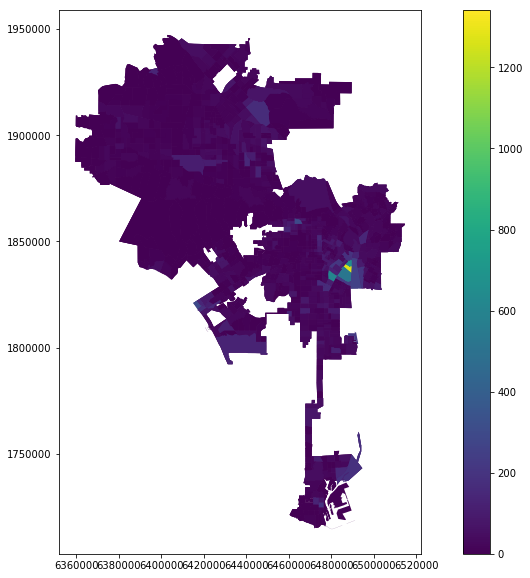

In [13]:
fig, ax = plt.subplots(figsize = (15, 10))
gdf2.plot(column='totUnshelt', ax=ax, legend=True)